# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

('Number of faces detected:', 1)


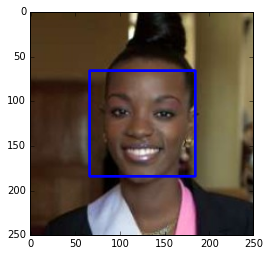

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__  Detecting human faces in human pictures:99% and detecting human faces in dog pictures:11%

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
performance_humans = [human for human in human_files_short if face_detector(human)]
performance_dogs = [dog for dog in dog_files_short if face_detector(dog)]
  
print "Detecting human faces in human pictures:{}%".format(len(performance_humans))
print "Detecting human faces in dog pictures:{}%".format(len(performance_dogs))

Detecting human faces in human pictures:99%
Detecting human faces in dog pictures:11%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ Depending on the context this might be reasonable. As the app is for fun it should be easy to communicate to the user. There could be some lines or messages on the screen to convey when a face is clearly read by the algorithm.

It would be unacceptable, for example, as a new Iphone face-recognition based locking mechanism. It would be very frustrating for the user if they woke up in the morning (as an example) and would have to perfectly light and align their face before they can check who sent them a text message. 
For this image augmentation could be used for further training. If I understand it correctly than this algorithm uses weak classifiers and based on what I've learned it should then look for lines. 
Furthermore, (though I am not sure if my intuition is correct) as the night vision functionality will lack quality: in a small phone it would have insufficient spectral and intensity range. This would not yield decent enough pictures for personal use, but it might be sufficient for the lock: if training on a dataset where the image quality is lessened, the images might be enough to recognize the user in dark.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

#### (Optional) TODO: Report the performance of another face detection algorithm on the LFW dataset. Feel free to use as many code cells as needed.

Did not get any good results neither for eye detection, nor alternative face detections...


In [ ]:
Dont implement this until the end!

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline   

human_files_short = human_files[:1000]
dog_files_short = train_files[:1000]
# Do NOT modify the code above this line.

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
# extract pre-trained eye detector
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
img = cv2.imread(human_files[0])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
eyes = eye_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))
print('Number of eyes detected:', len(eyes))

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [ ]:
Dont implement this until the end!
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path, classifier):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = classifier.detectMultiScale(gray)
    return len(faces) > 0

def performance(face_detector, classifier, true_files, false_files):
    #This function originates from http://www.the-charlie.com/ml/wp-content/uploads/2017/06/reports/dogs/report.html
    fp = 0
    tp = 0 
    fn = 0
    tn = 0
    ttl = len(true_files) + len(false_files)

    for h in true_files:
        has_face = face_detector(h, classifier)
        if not has_face:        
            fn += 1
        else: tp += 1

    for d in false_files:
        has_face = face_detector(d, classifier)
        if has_face:
            fp += 1
        else : tn += 1

    #recall = (tp / (tp + fp))*100
    precision = (tp / (tp + fn ))*100
    accuracy = (float(tp + tn) / ttl ) * 100

    print("ACCURACY={}%\n\tPrecision = {}%\n\tTrue Positives={}\n\tFalse Positives={}\n\tFalse Negatives={}\n\tTrue Negatives={}\n\tTOTAL={}".format( 
          accuracy, precision, tp, fp, fn, tn, ttl)) #n\tRecall = {}%\   recall, 

for i in range(0,3):
    classifier = [["lbpcascade_frontalface_improved", cv2.CascadeClassifier('lbpcascades/lbpcascade_frontalface_improved.xml')],
                  ["haarcascade_frontalface_alt2", cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')],
                 ["haarcascade_frontalface_alt_tree", cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt_tree.xml')]]
    print classifier[i][0]
    performance(face_detector, classifier[i][1], human_files_short,dog_files_short)
    performance(face_detector, classifier[i][1], dog_files_short, human_files_short)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ Detecting dogs in human pictures:1% and detecting dogs in dog pictures:99%

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

performance_humans = [human for human in human_files_short if dog_detector(human)]
performance_dogs = [dog for dog in dog_files_short if dog_detector(dog)]
  
print "Detecting dogs in human pictures:{}%".format(len(performance_humans))
print "Detecting dogs in dog pictures:{}%".format(len(performance_dogs))


Detecting dogs in human pictures:1%
Detecting dogs in dog pictures:99%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 266.90it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

Step 1. Types and sequence of layers. 
I experimented a few variations but kept in mind the recommendation to decrease the width and height and increase the depth of the layers. This was established a convolutional layers together with pooling layers.

Step 2. Number of filters.
I didn't find good rules of thumb for filters, but intuitively one could explain that the number of filters at different levels could be connected to how many different features are to be detected.
As far as I can understand having more neurons would increase the risk of overfitting. To reduce that risk more data and augmenting data would help. This would demand more training time per epoch and more epochs to find optimal values for the weights. Therefore I decided to stay in smaller numbers. This is similar to the [rule of thumb](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw):'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'. This however does not seem to be the case for CNN-s.
Although I can't explain why, I have seen many people use multiples of numbers for consecutive convolutional filters. 

Step 3. Dropout layer.
The dropout layer helped, but not that much so I decided to not use it.

Step 4. Activation function and optimizer.
I decided to go with the recommendations of 'relu' and 'rmsprop'.

Accuracy 8%.

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
input_shape=(224, 224, 3)
# Three pairs of convolutional + pooling layers to transform the net from a large area to depth as taught in lectures.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))  
# Flattening the filters for the final dense fully connected layer.
model.add(Flatten())
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
__________

### Compile the Model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [16]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
'''
Couldn't figure out how to make the augmenting work.

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

'''

epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 38s - loss: 4.7451 - acc: 0.0295 - val_loss: 4.5311 - val_acc: 0.0599
Epoch 2/100
6680/6680 [==============================] - 38s - loss: 4.0272 - acc: 0.1214 - val_loss: 4.3342 - val_acc: 0.0958
Epoch 3/100
6680/6680 [==============================] - 37s - loss: 2.5303 - acc: 0.4214 - val_loss: 4.7325 - val_acc: 0.1066
Epoch 4/100
6680/6680 [==============================] - 38s - loss: 0.8953 - acc: 0.7892 - val_loss: 5.9415 - val_acc: 0.0982
Epoch 5/100
6680/6680 [==============================] - 37s - loss: 0.2540 - acc: 0.9374 - val_loss: 7.6482 - val_acc: 0.0886
Epoch 6/100
6680/6680 [==============================] - 38s - loss: 0.0843 - acc: 0.9792 - val_loss: 9.7649 - val_acc: 0.0934
Epoch 7/100
6680/6680 [==============================] - 38s - loss: 0.0449 - acc: 0.9895 - val_loss: 8.9137 - val_acc: 0.0982
Epoch 8/100
6680/6680 [==============================] - 38s - l

6680/6680 [==============================] - 37s - loss: 0.0133 - acc: 0.9982 - val_loss: 10.1631 - val_acc: 0.0814
Epoch 34/100
6680/6680 [==============================] - 37s - loss: 0.0151 - acc: 0.9982 - val_loss: 9.8705 - val_acc: 0.0754
Epoch 35/100
6680/6680 [==============================] - 37s - loss: 0.0120 - acc: 0.9981 - val_loss: 9.6519 - val_acc: 0.0611
Epoch 36/100
6680/6680 [==============================] - 37s - loss: 0.0122 - acc: 0.9982 - val_loss: 10.1188 - val_acc: 0.0778
Epoch 37/100
6680/6680 [==============================] - 36s - loss: 0.0152 - acc: 0.9988 - val_loss: 12.1136 - val_acc: 0.0766
Epoch 38/100
6680/6680 [==============================] - 36s - loss: 0.0152 - acc: 0.9990 - val_loss: 11.9759 - val_acc: 0.0719
Epoch 39/100
6680/6680 [==============================] - 36s - loss: 0.0151 - acc: 0.9987 - val_loss: 11.3037 - val_acc: 0.0766
Epoch 40/100
6680/6680 [==============================] - 37s - loss: 0.0130 - acc: 0.9985 - val_loss: 11.1205 -

6680/6680 [==============================] - 37s - loss: 0.0180 - acc: 0.9981 - val_loss: 12.0768 - val_acc: 0.0551
Epoch 67/100
6680/6680 [==============================] - 37s - loss: 0.0177 - acc: 0.9984 - val_loss: 12.5113 - val_acc: 0.0563
Epoch 68/100
6680/6680 [==============================] - 36s - loss: 0.0188 - acc: 0.9979 - val_loss: 12.0973 - val_acc: 0.0539
Epoch 69/100
6680/6680 [==============================] - 37s - loss: 0.0153 - acc: 0.9984 - val_loss: 11.4833 - val_acc: 0.0707
Epoch 70/100
6680/6680 [==============================] - 37s - loss: 0.0139 - acc: 0.9984 - val_loss: 11.3609 - val_acc: 0.0695
Epoch 71/100
6680/6680 [==============================] - 37s - loss: 0.0114 - acc: 0.9985 - val_loss: 12.3652 - val_acc: 0.0539
Epoch 72/100
6680/6680 [==============================] - 37s - loss: 0.0130 - acc: 0.9985 - val_loss: 10.8171 - val_acc: 0.0599
Epoch 73/100
6680/6680 [==============================] - 37s - loss: 0.0125 - acc: 0.9985 - val_loss: 11.7100

6680/6680 [==============================] - 37s - loss: 0.0152 - acc: 0.9982 - val_loss: 13.2902 - val_acc: 0.0431
Epoch 100/100
6680/6680 [==============================] - 36s - loss: 0.0127 - acc: 0.9987 - val_loss: 13.5278 - val_acc: 0.0539


### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 8.0000%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.9142 - acc: 0.1040 - val_loss: 11.5707 - val_acc: 0.1844
Epoch 2/20
6680/6680 [==============================] - 0s - loss: 11.0271 - acc: 0.2400 - val_loss: 11.1523 - val_acc: 0.2263
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 10.6891 - acc: 0.2874 - val_loss: 10.8975 - val_acc: 0.2611
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 10.5554 - acc: 0.3084 - val_loss: 10.8957 - val_acc: 0.2719
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 10.4024 - acc: 0.3228 - val_loss: 10.6981 - val_acc: 0.2731
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 10.3012 - acc: 0.3413 - val_loss: 10.6567 - val_acc: 0.2898
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 10.1989 - acc: 0.3500 - val_loss: 10.5570 - val_acc: 0.2946
Epoch 8/20
6680/6680 [==============================] - 1s - los

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.0000%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Step 1. After running the initial trial with the same architecture as in step 4, I found that [Charlie Sanders](http://www.the-charlie.com/ml/wp-content/uploads/2017/06/reports/dogs/report.html) had used a GridSearchCV from Sklearn through the KerasClassifier wrapper to search through hyperparameters. 
Since RandomizedSearchCV should be more [efficient](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html) I tried to use that instead, but for some reason did not get it to work.

I experimented with VGG-19 and testing different architectures up to three convolutional layers with pooling and a dropout layers in the middle that sometimes turns itself off.
Besides different number of layers I ran the search through these hyperparameters:

optimizer = ['rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
I decided to ditch 'sgd' as it is hesitant near optimal solutions and other filters might take longer to find the path to an optimal solution. In other words: 'sgd' is less stable than others. Momentum can lessen this effect, but according to [this blog](http://www.erogol.com/comparison-sgd-vs-momentum-vs-rmsprop-vs-momentumrmsprop/) the change in gradient direction might diminish the momentum. According to [this blog](http://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) other methods have pros and cons and seem to the untrained eye like black magic, so I left them in.

filters = [16, 32, 64, 128, 256]

dropout_rate = [0.0, 0.25, 0.5]
I also thought about testing different pool sizes, but as I don't have many neurons decided to stick with a pool size of 2 and instead play with the dropout rate, which also seems like black magic at the moment. I had the question of whether to apply pooling before or after dropout as I can't put my finger on whether it is important or not. I found people having success with both cases.

I decided not to tinker with the learning rate and momentum as recommended by more experienced users. I also did not try other activation functions as 'relu' is strongly advised by Udacity.

The search was run with 20 epochs and a batch size of 150. The optimal model had two convolutional layers and a poolin and dropout layer in between. However, further training only yielde slightly better accuracy than the threshold of 60%.

Step 2. I read more about the different bottleneck feature characteristics and found that Resnet50 should run faster and yielded [better results](https://github.com/jcjohnson/cnn-benchmarks) in areas where VGG bottlenecks did not perform well. I also read that the Residual Network tackled the vanishing gradient with a very nice method, which might have been why VGG got stuck. It was also described that Resnet might overfit so I created a two step grid search where in the first it used convolutional layers and in the second it used a very simple architecture and only compared different optimization algorithms.

Step 3. While a more complex architecture yielded a testing accuracy up to 77% the more complex one gave an accuracy over 80%. Therefore further on I used the simpler architecture with 'nadam' optimizer and achieved an accuracy of 83% in the final test. This result with 17 epochs and batch size 150.

Predictive Entropy Search could be very useful and I am applying it in a Mechanical Engineering optimization problem. So far I have only found [Spearmint](https://github.com/HIPS/Spearmint) by Harvard, but would love to learn some alternatives as I would need to learn to use MongoDB to tinker around with that tool.

In [27]:
### TODO: Define your architecture.
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10)
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

#create a model function for GridSearchCV with an option to try with and without convolutional alyers
def create_model(conv, optimizer, filters, dropout_rate, shape):    
    Resnet50_model = Sequential()
    if conv == 1:
        Resnet50_model.add(Conv2D(filters=filters, kernel_size=2, padding='same', activation='relu', input_shape=shape))
        Resnet50_model.add(Dropout(dropout_rate))
        Resnet50_model.add(Flatten())
    else:
        Resnet50_model.add(GlobalAveragePooling2D(input_shape=shape))
    Resnet50_model.add(Dense(133, activation='softmax'))
    Resnet50_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return Resnet50_model

model = KerasClassifier(build_fn=create_model,epochs=20, batch_size=150, verbose=2)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

In [33]:
# Set a parameter grid to run with convolutional layers:
optimizer = ['rmsprop', 'adam', 'adamax', 'nadam']
filters = [16, 32]
dropout_rate = [0.0, 0.25, 0.5]
conv = [1]
shapes = [train_Resnet50.shape[1:]]
param_grid = dict(conv=conv, optimizer=optimizer, filters=filters, dropout_rate=dropout_rate, shape=shapes)
# Run the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, fit_params={'callbacks':[checkpointer,early_stop] ,'validation_data' : (valid_Resnet50, valid_targets)})
grid.fit(train_Resnet50, train_targets)

Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 4.38808, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 4.6560 - acc: 0.0454 - val_loss: 4.3881 - val_acc: 0.0766
Epoch 2/20
Epoch 00001: val_loss improved from 4.38808 to 3.89374, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 4.0859 - acc: 0.1289 - val_loss: 3.8937 - val_acc: 0.1677
Epoch 3/20
Epoch 00002: val_loss improved from 3.89374 to 3.36326, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 3.5351 - acc: 0.2266 - val_loss: 3.3633 - val_acc: 0.2443
Epoch 4/20
Epoch 00003: val_loss improved from 3.36326 to 2.85783, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 2.9619 - acc: 0.3429 - val_loss: 2.8578 - val_acc: 0.3605
Epoch 5/20
Epoch 00004: val_loss improved from 2.85783 to 2.42963, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 2.4514 - acc: 0.4453 - val_loss: 2.4296 - val_acc: 0.43

Epoch 00017: val_loss did not improve
0s - loss: 1.0892 - acc: 0.6985 - val_loss: 1.4588 - val_acc: 0.5796
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 1.0408 - acc: 0.7160 - val_loss: 1.4013 - val_acc: 0.6048
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 0.9889 - acc: 0.7243 - val_loss: 1.3867 - val_acc: 0.6204
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.7596 - acc: 0.0238 - val_loss: 4.5724 - val_acc: 0.0479
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 4.3706 - acc: 0.0725 - val_loss: 4.2059 - val_acc: 0.1006
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 3.9171 - acc: 0.1525 - val_loss: 3.7529 - val_acc: 0.1952
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 3.3952 - acc: 0.2605 - val_loss: 3.2567 - val_acc: 0.2850
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 2.8554 - acc: 0.3546 - val_loss: 2.7578 - val_acc: 0.3641
Epoch 6/20
Epoch 0

Epoch 00002: val_loss did not improve
0s - loss: 3.5525 - acc: 0.2237 - val_loss: 3.3851 - val_acc: 0.2551
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 2.9600 - acc: 0.3681 - val_loss: 2.8415 - val_acc: 0.3653
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 2.4351 - acc: 0.4747 - val_loss: 2.3984 - val_acc: 0.4587
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 2.0222 - acc: 0.5583 - val_loss: 2.0672 - val_acc: 0.5222
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 1.7179 - acc: 0.6171 - val_loss: 1.8383 - val_acc: 0.5557
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 1.4929 - acc: 0.6593 - val_loss: 1.6633 - val_acc: 0.5940
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 1.3247 - acc: 0.6921 - val_loss: 1.5435 - val_acc: 0.6096
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 1.1897 - acc: 0.7242 - val_loss: 1.4419 - val_acc: 0.6240
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 1.085

Epoch 00010: val_loss did not improve
0s - loss: 0.7431 - acc: 0.7876 - val_loss: 1.1764 - val_acc: 0.6683
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 0.6910 - acc: 0.8078 - val_loss: 1.1711 - val_acc: 0.6623
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 0.6449 - acc: 0.8217 - val_loss: 1.1360 - val_acc: 0.6754
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 0.6029 - acc: 0.8316 - val_loss: 1.1289 - val_acc: 0.6695
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 0.5667 - acc: 0.8412 - val_loss: 1.0860 - val_acc: 0.6898
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 0.5316 - acc: 0.8534 - val_loss: 1.1086 - val_acc: 0.6683
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 0.5057 - acc: 0.8585 - val_loss: 1.0993 - val_acc: 0.6826
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 0.4771 - acc: 0.8684 - val_loss: 1.0901 - val_acc: 0.6826
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss:

Epoch 00017: val_loss improved from 0.85184 to 0.84303, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 0.2493 - acc: 0.9479 - val_loss: 0.8430 - val_acc: 0.7473
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 0.2249 - acc: 0.9571 - val_loss: 0.8493 - val_acc: 0.7569
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 0.2037 - acc: 0.9643 - val_loss: 0.8570 - val_acc: 0.7473
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.3738 - acc: 0.0817 - val_loss: 3.8179 - val_acc: 0.2060
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 3.2707 - acc: 0.3090 - val_loss: 2.8904 - val_acc: 0.3808
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 2.3620 - acc: 0.4967 - val_loss: 2.1833 - val_acc: 0.5138
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 1.7525 - acc: 0.6119 - val_loss: 1.8029 - val_acc: 0.5581
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 1.

Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.5380 - acc: 0.0883 - val_loss: 4.0781 - val_acc: 0.1832
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 3.4624 - acc: 0.2922 - val_loss: 3.0231 - val_acc: 0.3665
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 2.3212 - acc: 0.5122 - val_loss: 2.0812 - val_acc: 0.5365
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 1.5332 - acc: 0.6623 - val_loss: 1.5585 - val_acc: 0.6275
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 1.1118 - acc: 0.7397 - val_loss: 1.2830 - val_acc: 0.6778
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 0.8757 - acc: 0.7869 - val_loss: 1.1267 - val_acc: 0.7030
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 0.7275 - acc: 0.8248 - val_loss: 1.0378 - val_acc: 0.7042
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 0.6166 - acc: 0.8534 - val_loss: 0.9727 - val_acc: 0.7305
Epoch 9/2

Epoch 00008: val_loss did not improve
0s - loss: 0.8511 - acc: 0.8080 - val_loss: 1.1723 - val_acc: 0.6898
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 0.7672 - acc: 0.8287 - val_loss: 1.1085 - val_acc: 0.6910
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 0.6935 - acc: 0.8473 - val_loss: 1.0479 - val_acc: 0.7210
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 0.6327 - acc: 0.8605 - val_loss: 1.0094 - val_acc: 0.7198
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 0.5824 - acc: 0.8693 - val_loss: 0.9927 - val_acc: 0.7281
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 0.5407 - acc: 0.8794 - val_loss: 0.9464 - val_acc: 0.7317
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 0.4960 - acc: 0.8927 - val_loss: 0.9205 - val_acc: 0.7473
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 0.4669 - acc: 0.9016 - val_loss: 0.9076 - val_acc: 0.7401
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss:

Epoch 00014: val_loss did not improve
0s - loss: 0.1511 - acc: 0.9796 - val_loss: 0.7429 - val_acc: 0.7689
Epoch 16/20
Epoch 00015: val_loss improved from 0.72978 to 0.70056, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 0.1342 - acc: 0.9841 - val_loss: 0.7006 - val_acc: 0.7820
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 0.1201 - acc: 0.9868 - val_loss: 0.7025 - val_acc: 0.7880
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 0.1051 - acc: 0.9906 - val_loss: 0.7316 - val_acc: 0.7689
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 0.0946 - acc: 0.9915 - val_loss: 0.7223 - val_acc: 0.7868
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 0.0836 - acc: 0.9942 - val_loss: 0.7178 - val_acc: 0.7772
Train on 4454 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.3287 - acc: 0.0972 - val_loss: 3.5798 - val_acc: 0.2144
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss:

Epoch 00001: val_loss did not improve
0s - loss: 4.5474 - acc: 0.0485 - val_loss: 4.3837 - val_acc: 0.1150
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 4.3103 - acc: 0.0815 - val_loss: 4.1407 - val_acc: 0.1473
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 4.0951 - acc: 0.1001 - val_loss: 3.8709 - val_acc: 0.1856
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 3.8992 - acc: 0.1194 - val_loss: 3.6336 - val_acc: 0.2431
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 3.7231 - acc: 0.1441 - val_loss: 3.4398 - val_acc: 0.2599
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 3.5407 - acc: 0.1664 - val_loss: 3.2267 - val_acc: 0.3054
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 3.3917 - acc: 0.1915 - val_loss: 3.0363 - val_acc: 0.3557
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 3.2863 - acc: 0.2088 - val_loss: 2.8679 - val_acc: 0.3784
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 3.1517

Epoch 00009: val_loss did not improve
0s - loss: 2.2934 - acc: 0.3958 - val_loss: 1.7211 - val_acc: 0.6204
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 2.1921 - acc: 0.4048 - val_loss: 1.6201 - val_acc: 0.6347
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 2.1069 - acc: 0.4216 - val_loss: 1.5399 - val_acc: 0.6491
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 2.0812 - acc: 0.4270 - val_loss: 1.4818 - val_acc: 0.6587
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 2.0074 - acc: 0.4396 - val_loss: 1.4445 - val_acc: 0.6551
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 1.9262 - acc: 0.4558 - val_loss: 1.3641 - val_acc: 0.6802
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 1.8759 - acc: 0.4769 - val_loss: 1.3316 - val_acc: 0.6802
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 1.8508 - acc: 0.4699 - val_loss: 1.2983 - val_acc: 0.6910
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss:

Epoch 00017: val_loss did not improve
0s - loss: 2.1157 - acc: 0.4216 - val_loss: 1.5467 - val_acc: 0.6275
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 2.0612 - acc: 0.4324 - val_loss: 1.4986 - val_acc: 0.6395
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 2.0073 - acc: 0.4423 - val_loss: 1.4678 - val_acc: 0.6491
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.7274 - acc: 0.0272 - val_loss: 4.4348 - val_acc: 0.0731
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 4.1994 - acc: 0.0901 - val_loss: 3.8549 - val_acc: 0.1581
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 3.7811 - acc: 0.1269 - val_loss: 3.3720 - val_acc: 0.2563
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 3.4419 - acc: 0.1713 - val_loss: 2.9886 - val_acc: 0.3150
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 3.1979 - acc: 0.2079 - val_loss: 2.6496 - val_acc: 0.4024
Epoch 6/20
Epoch 0

Epoch 00005: val_loss did not improve
0s - loss: 2.6905 - acc: 0.3501 - val_loss: 2.2470 - val_acc: 0.5102
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 2.4504 - acc: 0.3723 - val_loss: 1.9859 - val_acc: 0.5737
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 2.2427 - acc: 0.4251 - val_loss: 1.8108 - val_acc: 0.5796
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 2.0883 - acc: 0.4518 - val_loss: 1.6460 - val_acc: 0.5976
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 1.9457 - acc: 0.4687 - val_loss: 1.4945 - val_acc: 0.6419
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 1.8513 - acc: 0.4909 - val_loss: 1.4121 - val_acc: 0.6719
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 1.7435 - acc: 0.5077 - val_loss: 1.3168 - val_acc: 0.6778
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 1.6359 - acc: 0.5300 - val_loss: 1.2575 - val_acc: 0.6994
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 1.

Epoch 00013: val_loss did not improve
0s - loss: 1.2911 - acc: 0.6243 - val_loss: 1.0162 - val_acc: 0.7246
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 1.2655 - acc: 0.6317 - val_loss: 0.9991 - val_acc: 0.7269
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 1.2241 - acc: 0.6407 - val_loss: 0.9720 - val_acc: 0.7317
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 1.1463 - acc: 0.6589 - val_loss: 0.9553 - val_acc: 0.7377
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 1.1361 - acc: 0.6656 - val_loss: 0.9167 - val_acc: 0.7533
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 1.0877 - acc: 0.6701 - val_loss: 0.9128 - val_acc: 0.7437
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 1.0796 - acc: 0.6712 - val_loss: 0.8878 - val_acc: 0.7557
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.7317 - acc: 0.0350 - val_loss: 4.4378 - val_acc: 0.0838
Epoch 2/20
Epo

Epoch 00001: val_loss did not improve
0s - loss: 4.1723 - acc: 0.1105 - val_loss: 3.8873 - val_acc: 0.2000
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 3.6844 - acc: 0.1893 - val_loss: 3.3216 - val_acc: 0.3246
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 3.2151 - acc: 0.2627 - val_loss: 2.8004 - val_acc: 0.4156
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 2.8159 - acc: 0.3285 - val_loss: 2.4070 - val_acc: 0.5198
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 2.5379 - acc: 0.3773 - val_loss: 2.1038 - val_acc: 0.5820
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 2.3058 - acc: 0.4190 - val_loss: 1.8712 - val_acc: 0.6240
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 2.1209 - acc: 0.4485 - val_loss: 1.6904 - val_acc: 0.6299
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 2.0311 - acc: 0.4693 - val_loss: 1.5772 - val_acc: 0.6635
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 1.8830

Epoch 00009: val_loss did not improve
0s - loss: 1.0940 - acc: 0.6676 - val_loss: 0.8682 - val_acc: 0.7533
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 1.0659 - acc: 0.6804 - val_loss: 0.8502 - val_acc: 0.7437
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 0.9794 - acc: 0.6975 - val_loss: 0.8029 - val_acc: 0.7581
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 0.9364 - acc: 0.7051 - val_loss: 0.8033 - val_acc: 0.7485
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 0.9300 - acc: 0.7117 - val_loss: 0.7933 - val_acc: 0.7641
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 0.8997 - acc: 0.7258 - val_loss: 0.7847 - val_acc: 0.7569
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 0.8426 - acc: 0.7370 - val_loss: 0.7719 - val_acc: 0.7701
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 0.8200 - acc: 0.7532 - val_loss: 0.7685 - val_acc: 0.7653
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss:

Epoch 00017: val_loss did not improve
0s - loss: 3.5911 - acc: 0.1114 - val_loss: 2.8822 - val_acc: 0.3796
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 3.5512 - acc: 0.1204 - val_loss: 2.7864 - val_acc: 0.3952
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 3.5658 - acc: 0.1163 - val_loss: 2.7932 - val_acc: 0.3976
Train on 4454 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
0s - loss: 4.8668 - acc: 0.0135 - val_loss: 4.7893 - val_acc: 0.0180
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 4.7523 - acc: 0.0198 - val_loss: 4.6606 - val_acc: 0.0228
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 4.6453 - acc: 0.0236 - val_loss: 4.5328 - val_acc: 0.0503
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 4.5357 - acc: 0.0355 - val_loss: 4.3837 - val_acc: 0.0766
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 4.4335 - acc: 0.0476 - val_loss: 4.2329 - val_acc: 0.1138
Epoch 6/20
Epoch 0

Epoch 00006: val_loss did not improve
0s - loss: 3.8474 - acc: 0.1062 - val_loss: 3.3544 - val_acc: 0.2934
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 3.7679 - acc: 0.1044 - val_loss: 3.2185 - val_acc: 0.3054
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 3.6596 - acc: 0.1239 - val_loss: 3.0720 - val_acc: 0.3653
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 3.6273 - acc: 0.1206 - val_loss: 2.9947 - val_acc: 0.3856
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 3.5097 - acc: 0.1336 - val_loss: 2.8681 - val_acc: 0.4263
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 3.5021 - acc: 0.1309 - val_loss: 2.8014 - val_acc: 0.4216
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 3.4659 - acc: 0.1439 - val_loss: 2.7338 - val_acc: 0.4539
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 3.4015 - acc: 0.1477 - val_loss: 2.6317 - val_acc: 0.4623
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 3

Epoch 00014: val_loss did not improve
0s - loss: 3.5478 - acc: 0.1347 - val_loss: 2.9501 - val_acc: 0.4168
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 3.4830 - acc: 0.1477 - val_loss: 2.8570 - val_acc: 0.4359
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 3.4417 - acc: 0.1560 - val_loss: 2.8080 - val_acc: 0.4311
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 3.3932 - acc: 0.1652 - val_loss: 2.7585 - val_acc: 0.4635
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 3.3885 - acc: 0.1518 - val_loss: 2.6484 - val_acc: 0.4802
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 3.3569 - acc: 0.1612 - val_loss: 2.6286 - val_acc: 0.4874
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
1s - loss: 4.8293 - acc: 0.0173 - val_loss: 4.6604 - val_acc: 0.0563
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 4.5918 - acc: 0.0391 - val_loss: 4.3460 - val_acc: 0.1186
Epoch 3/20
Epoc

Epoch 00002: val_loss did not improve
0s - loss: 4.2159 - acc: 0.0889 - val_loss: 3.8024 - val_acc: 0.2299
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 3.8964 - acc: 0.1302 - val_loss: 3.4493 - val_acc: 0.3305
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 3.6016 - acc: 0.1709 - val_loss: 3.0939 - val_acc: 0.3856
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 3.3623 - acc: 0.1967 - val_loss: 2.7107 - val_acc: 0.4707
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 3.1198 - acc: 0.2392 - val_loss: 2.4383 - val_acc: 0.5269
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 2.9176 - acc: 0.2645 - val_loss: 2.2167 - val_acc: 0.5581
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 2.7843 - acc: 0.2863 - val_loss: 1.9929 - val_acc: 0.6084
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 2.6402 - acc: 0.3126 - val_loss: 1.8506 - val_acc: 0.6287
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 2.535

Epoch 00010: val_loss did not improve
0s - loss: 2.4094 - acc: 0.3519 - val_loss: 1.5631 - val_acc: 0.6790
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 2.3622 - acc: 0.3575 - val_loss: 1.4840 - val_acc: 0.7090
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 2.2552 - acc: 0.3784 - val_loss: 1.4209 - val_acc: 0.7090
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 2.2362 - acc: 0.3687 - val_loss: 1.3839 - val_acc: 0.7186
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 2.1742 - acc: 0.3838 - val_loss: 1.3581 - val_acc: 0.7054
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 2.1503 - acc: 0.3885 - val_loss: 1.2773 - val_acc: 0.7317
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 2.0787 - acc: 0.4031 - val_loss: 1.2608 - val_acc: 0.7162
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 2.0450 - acc: 0.4204 - val_loss: 1.1978 - val_acc: 0.7150
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss:

Epoch 00018: val_loss did not improve
0s - loss: 2.6902 - acc: 0.2942 - val_loss: 1.8654 - val_acc: 0.6275
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 2.6536 - acc: 0.2892 - val_loss: 1.8070 - val_acc: 0.6539
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
1s - loss: 4.8000 - acc: 0.0220 - val_loss: 4.5838 - val_acc: 0.0934
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 4.4929 - acc: 0.0546 - val_loss: 4.2224 - val_acc: 0.1928
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 4.2050 - acc: 0.0912 - val_loss: 3.8987 - val_acc: 0.2611
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 3.9611 - acc: 0.1282 - val_loss: 3.5865 - val_acc: 0.3257
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 3.7321 - acc: 0.1558 - val_loss: 3.2676 - val_acc: 0.3760
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 3.5432 - acc: 0.1806 - val_loss: 3.0357 - val_acc: 0.4335
Epoch 7/20
Epoch 00

Epoch 00006: val_loss did not improve
0s - loss: 3.0374 - acc: 0.2093 - val_loss: 2.0589 - val_acc: 0.6156
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 2.9185 - acc: 0.2380 - val_loss: 1.9528 - val_acc: 0.6263
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 2.8439 - acc: 0.2407 - val_loss: 1.8430 - val_acc: 0.6479
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 2.7925 - acc: 0.2403 - val_loss: 1.7908 - val_acc: 0.6599
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 2.7382 - acc: 0.2493 - val_loss: 1.7072 - val_acc: 0.6527
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 2.6693 - acc: 0.2630 - val_loss: 1.6452 - val_acc: 0.6479
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 2.6568 - acc: 0.2612 - val_loss: 1.5923 - val_acc: 0.6503
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 2.6480 - acc: 0.2657 - val_loss: 1.5281 - val_acc: 0.6814
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 2

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbcb52acd50>,
       fit_params={'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x7fbc343e1690>, <keras.callbacks.EarlyStopping object at 0x7fbc343e1410>], 'validation_data': (array([[[[ 0.44296,  0.36804, ...,  0.40248,  0.12858]]],


       [[[ 0.     ,  0.05516, ...,  0.23273,  0.23311]]],


       ...,
  ... ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]]))},
       iid=True, n_jobs=1,
       param_grid={'shape': [(1, 1, 2048)], 'optimizer': ['rmsprop', 'adam', 'adamax', 'nadam'], 'dropout_rate': [0.0, 0.25, 0.5], 'conv': [1], 'filters': [16, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
#Get top 10 results from grid search with convolutional layers!
from pprint import pprint
a = grid.grid_scores_
b = sorted(range(len(a)), key=lambda i: a[i][1])[-10:]
print "top 10 results from grid search with convolutional layers"
for i in range(0,10):
    print a[b[i]][1]
    print a[b[i]][0]
print b

top 10 results from grid search with convolutional layers
0.719161665663
{'shape': (1, 1, 2048), 'dropout_rate': 0.5, 'optimizer': 'adam', 'filters': 32, 'conv': 1}
0.720359274129
{'shape': (1, 1, 2048), 'dropout_rate': 0.0, 'optimizer': 'nadam', 'filters': 16, 'conv': 1}
0.733832339916
{'shape': (1, 1, 2048), 'dropout_rate': 0.25, 'optimizer': 'adamax', 'filters': 32, 'conv': 1}
0.746107788589
{'shape': (1, 1, 2048), 'dropout_rate': 0.25, 'optimizer': 'rmsprop', 'filters': 32, 'conv': 1}
0.755389218273
{'shape': (1, 1, 2048), 'dropout_rate': 0.0, 'optimizer': 'rmsprop', 'filters': 32, 'conv': 1}
0.761526938854
{'shape': (1, 1, 2048), 'dropout_rate': 0.0, 'optimizer': 'adamax', 'filters': 32, 'conv': 1}
0.769011969418
{'shape': (1, 1, 2048), 'dropout_rate': 0.25, 'optimizer': 'adam', 'filters': 32, 'conv': 1}
0.769910177615
{'shape': (1, 1, 2048), 'dropout_rate': 0.25, 'optimizer': 'nadam', 'filters': 32, 'conv': 1}
0.770059874306
{'shape': (1, 1, 2048), 'dropout_rate': 0.0, 'optimizer

/home/simonx/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [47]:
# Change parameter grid to run without convolutional layers:
optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
filters = [0]
dropout_rate = [0]
conv = [0]
shapes = [train_Resnet50.shape[1:]]
param_grid = dict(conv=conv, optimizer=optimizer, filters=filters, dropout_rate=dropout_rate, shape=shapes)
# Run the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, fit_params={'callbacks':[checkpointer,early_stop] ,'validation_data' : (valid_Resnet50, valid_targets)})
grid.fit(train_Resnet50, train_targets)

Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 4.54725, saving model to saved_models/weights.best.Resnet50.hdf5
2s - loss: 4.9831 - acc: 0.0209 - val_loss: 4.5473 - val_acc: 0.0491
Epoch 2/20
Epoch 00001: val_loss improved from 4.54725 to 3.95720, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 4.2277 - acc: 0.1143 - val_loss: 3.9572 - val_acc: 0.1856
Epoch 3/20
Epoch 00002: val_loss improved from 3.95720 to 3.47169, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 3.6441 - acc: 0.2479 - val_loss: 3.4717 - val_acc: 0.3198
Epoch 4/20
Epoch 00003: val_loss improved from 3.47169 to 3.07064, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 3.1623 - acc: 0.3788 - val_loss: 3.0706 - val_acc: 0.4036
Epoch 5/20
Epoch 00004: val_loss improved from 3.07064 to 2.74327, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 2.7665 - acc: 0.4777 - val_loss: 2.7433 - val_acc: 0.46

Epoch 00016: val_loss did not improve
0s - loss: 1.0433 - acc: 0.8273 - val_loss: 1.3275 - val_acc: 0.7174
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 0.9935 - acc: 0.8348 - val_loss: 1.2854 - val_acc: 0.7234
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 0.9483 - acc: 0.8417 - val_loss: 1.2471 - val_acc: 0.7246
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 0.9075 - acc: 0.8502 - val_loss: 1.2127 - val_acc: 0.7293
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
2s - loss: 2.9733 - acc: 0.3683 - val_loss: 1.7835 - val_acc: 0.5772
Epoch 2/20
Epoch 00001: val_loss improved from 1.19454 to 1.11287, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 1.0568 - acc: 0.7741 - val_loss: 1.1129 - val_acc: 0.7222
Epoch 3/20
Epoch 00002: val_loss improved from 1.11287 to 0.91039, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 0.5686 - acc: 0.8830 - val_loss: 0.9104 - val

Epoch 00006: val_loss did not improve
0s - loss: 0.2528 - acc: 0.9838 - val_loss: 0.8106 - val_acc: 0.7928
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 0.2297 - acc: 0.9885 - val_loss: 0.7996 - val_acc: 0.7940
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 0.2127 - acc: 0.9910 - val_loss: 0.7928 - val_acc: 0.7988
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 0.1999 - acc: 0.9912 - val_loss: 0.7815 - val_acc: 0.7952
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 0.1889 - acc: 0.9915 - val_loss: 0.7772 - val_acc: 0.7964
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 0.1798 - acc: 0.9928 - val_loss: 0.7722 - val_acc: 0.7940
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 0.1723 - acc: 0.9928 - val_loss: 0.7700 - val_acc: 0.8024
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 0.1659 - acc: 0.9930 - val_loss: 0.7627 - val_acc: 0.7988
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 0

Epoch 00014: val_loss did not improve
0s - loss: 0.2004 - acc: 0.9843 - val_loss: 0.7185 - val_acc: 0.8024
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 0.1790 - acc: 0.9897 - val_loss: 0.6985 - val_acc: 0.8024
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 0.1609 - acc: 0.9906 - val_loss: 0.6886 - val_acc: 0.8192
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 0.1453 - acc: 0.9915 - val_loss: 0.6684 - val_acc: 0.8096
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 0.1308 - acc: 0.9944 - val_loss: 0.6636 - val_acc: 0.8048
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 0.1184 - acc: 0.9946 - val_loss: 0.6512 - val_acc: 0.8096
Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
2s - loss: 4.3219 - acc: 0.1172 - val_loss: 3.3256 - val_acc: 0.3054
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 2.5294 - acc: 0.5055 - val_loss: 2.2669 - val_acc: 0.5293
Epoch 3/20
Epoc

Epoch 00000: val_loss did not improve
2s - loss: 3.4110 - acc: 0.2924 - val_loss: 1.8295 - val_acc: 0.5892
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 1.0650 - acc: 0.7808 - val_loss: 1.0901 - val_acc: 0.7293
Epoch 3/20
Epoch 00002: val_loss did not improve
0s - loss: 0.5576 - acc: 0.9019 - val_loss: 0.8888 - val_acc: 0.7641
Epoch 4/20
Epoch 00003: val_loss did not improve
0s - loss: 0.3660 - acc: 0.9535 - val_loss: 0.8078 - val_acc: 0.7772
Epoch 5/20
Epoch 00004: val_loss did not improve
0s - loss: 0.2614 - acc: 0.9744 - val_loss: 0.7423 - val_acc: 0.7808
Epoch 6/20
Epoch 00005: val_loss did not improve
0s - loss: 0.1960 - acc: 0.9865 - val_loss: 0.6975 - val_acc: 0.7880
Epoch 7/20
Epoch 00006: val_loss did not improve
0s - loss: 0.1528 - acc: 0.9935 - val_loss: 0.6855 - val_acc: 0.7916
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 0.1227 - acc: 0.9962 - val_loss: 0.6546 - val_acc: 0.8048
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 0.0995 

Epoch 00006: val_loss did not improve
0s - loss: 0.2818 - acc: 0.9764 - val_loss: 0.7766 - val_acc: 0.7856
Epoch 8/20
Epoch 00007: val_loss did not improve
0s - loss: 0.2391 - acc: 0.9847 - val_loss: 0.7593 - val_acc: 0.7880
Epoch 9/20
Epoch 00008: val_loss did not improve
0s - loss: 0.2074 - acc: 0.9874 - val_loss: 0.7326 - val_acc: 0.7856
Epoch 10/20
Epoch 00009: val_loss did not improve
0s - loss: 0.1820 - acc: 0.9919 - val_loss: 0.7153 - val_acc: 0.8108
Epoch 11/20
Epoch 00010: val_loss did not improve
0s - loss: 0.1613 - acc: 0.9937 - val_loss: 0.7035 - val_acc: 0.8036
Epoch 12/20
Epoch 00011: val_loss did not improve
0s - loss: 0.1438 - acc: 0.9955 - val_loss: 0.6908 - val_acc: 0.8108
Epoch 13/20
Epoch 00012: val_loss did not improve
0s - loss: 0.1292 - acc: 0.9957 - val_loss: 0.6785 - val_acc: 0.8048
Epoch 14/20
Epoch 00013: val_loss did not improve
0s - loss: 0.1171 - acc: 0.9973 - val_loss: 0.6726 - val_acc: 0.8060
Epoch 15/20
Epoch 00014: val_loss did not improve
0s - loss: 0

Epoch 00014: val_loss did not improve
0s - loss: 0.0192 - acc: 0.9993 - val_loss: 0.6147 - val_acc: 0.8084
Epoch 16/20
Epoch 00015: val_loss did not improve
0s - loss: 0.0181 - acc: 0.9991 - val_loss: 0.6086 - val_acc: 0.8096
Epoch 17/20
Epoch 00016: val_loss did not improve
0s - loss: 0.0158 - acc: 0.9996 - val_loss: 0.6148 - val_acc: 0.8120
Epoch 18/20
Epoch 00017: val_loss did not improve
0s - loss: 0.0141 - acc: 0.9996 - val_loss: 0.6242 - val_acc: 0.8084
Epoch 19/20
Epoch 00018: val_loss did not improve
0s - loss: 0.0149 - acc: 0.9991 - val_loss: 0.6265 - val_acc: 0.8108
Epoch 20/20
Epoch 00019: val_loss did not improve
0s - loss: 0.0147 - acc: 0.9991 - val_loss: 0.6105 - val_acc: 0.8072
Train on 4454 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss did not improve
2s - loss: 2.7731 - acc: 0.3949 - val_loss: 1.3009 - val_acc: 0.6754
Epoch 2/20
Epoch 00001: val_loss did not improve
0s - loss: 0.6422 - acc: 0.8583 - val_loss: 0.8833 - val_acc: 0.7461
Epoch 3/20
Epoc

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbbb1cf6650>,
       fit_params={'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x7fbbafabff90>, <keras.callbacks.EarlyStopping object at 0x7fbc34640f50>], 'validation_data': (array([[[[ 0.44296,  0.36804, ...,  0.40248,  0.12858]]],


       [[[ 0.     ,  0.05516, ...,  0.23273,  0.23311]]],


       ...,
  ... ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]]))},
       iid=True, n_jobs=1,
       param_grid={'shape': [(1, 1, 2048)], 'optimizer': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam'], 'dropout_rate': [0], 'conv': [0], 'filters': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [54]:
#Get top 10 results from grid search!
from pprint import pprint
a = grid.grid_scores_
b = sorted(range(len(a)), key=lambda i: a[i][1])[-10:]
print "top 7 results from grid search without convolutional layers"
for i in range(0,7):
    print a[b[i]][1]
    print a[b[i]][0]
print b

top 7 results from grid search without convolutional layers
0.736676651766
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'sgd', 'filters': 0, 'conv': 0}
0.805239519673
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'adagrad', 'filters': 0, 'conv': 0}
0.808832331671
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'adadelta', 'filters': 0, 'conv': 0}
0.812125749244
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'rmsprop', 'filters': 0, 'conv': 0}
0.815119752796
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'adam', 'filters': 0, 'conv': 0}
0.816017958004
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'adamax', 'filters': 0, 'conv': 0}
0.820958088936
{'shape': (1, 1, 2048), 'dropout_rate': 0, 'optimizer': 'nadam', 'filters': 0, 'conv': 0}
[0, 2, 3, 1, 4, 5, 6]


/home/simonx/.local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### (IMPLEMENTATION) Compile the Model

In [28]:
### TODO: Compile the model.
#Let's select the best architecture (the one without the convolutional layer) and the best ranking optimizer 'nadam'
optimizer = 'nadam'
filters = 0
dropout_rate = 0
conv = 0
shapes = train_Resnet50.shape[1:]

Resnet50_model = create_model(conv=conv, optimizer=optimizer, filters=filters, dropout_rate=dropout_rate, shape=shapes)
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')
Resnet50_model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [29]:
### TODO: Train the model.

Resnet50_model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),
                epochs=100, batch_size=150, callbacks=[checkpointer,early_stop], verbose=2)


Train on 6680 samples, validate on 835 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 0.84040, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 0.0068 - acc: 0.9987 - val_loss: 0.8404 - val_acc: 0.8275
Epoch 2/100
Epoch 00001: val_loss improved from 0.84040 to 0.83374, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 0.0086 - acc: 0.9982 - val_loss: 0.8337 - val_acc: 0.8359
Epoch 3/100
Epoch 00002: val_loss improved from 0.83374 to 0.79803, saving model to saved_models/weights.best.Resnet50.hdf5
0s - loss: 0.0070 - acc: 0.9981 - val_loss: 0.7980 - val_acc: 0.8311
Epoch 4/100
Epoch 00003: val_loss did not improve
0s - loss: 0.0062 - acc: 0.9988 - val_loss: 0.8646 - val_acc: 0.8263
Epoch 5/100
Epoch 00004: val_loss did not improve
0s - loss: 0.0463 - acc: 0.9858 - val_loss: 0.9833 - val_acc: 0.8156
Epoch 6/100
Epoch 00005: val_loss did not improve
0s - loss: 0.0070 - acc: 0.9982 - val_loss: 0.9605 - val_acc: 0.8132
Epoch 7/100
Epoch 000

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [30]:
### TODO: Load the model weights with the best validation loss.

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [31]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0000%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

#Compile the model
optimizer = 'nadam'
filters = 0
dropout_rate = 0
conv = 0
shapes = train_Resnet50.shape[1:]

Resnet50_model = create_model(conv=conv, optimizer=optimizer, filters=filters, dropout_rate=dropout_rate, shape=shapes)
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

def predict_breed(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]


In [35]:
#Let's test it!
predict_breed("images/American_water_spaniel_00648.jpg")

'Irish_water_spaniel'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [43]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed
import os 
import random 
from random import shuffle
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from scipy.misc import imread

def display_img(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    plt.show()

def whichDogBreed(img_path):
    # detect if image has human or dog
    human = face_detector(img_path)
    dog = dog_detector(img_path)
    breed = predict_breed(img_path)
    
    if human and dog: 
        print("Detected human and dog. You look like a:")
        print breed
    elif human: 
        print "This human looks like"
        print breed
    elif dog:
        print "This dog seems to be a"
        print breed
    else:
        print "are you sure someone is in this picture?"
    display_img(img_path)

This dog seems to be a
Irish_water_spaniel


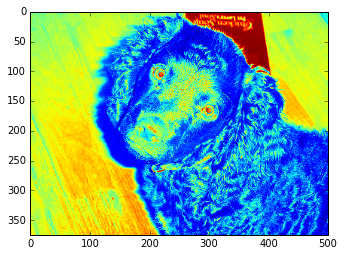

In [44]:
#Let's test it!
whichDogBreed("images/American_water_spaniel_00648.jpg")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It is better than I expected. It was really cool that it detected my German Shephard from an old photo! 
At the same time it mixed up the American and Irish water spaniels, which when googling seems difficult for others' algorithms as well.
1. One major improvement to make is augmentation: flipping, resizing etc. Also just adding more data.
2. Retraining the face detector with a solid transfered architecture.
3. Use an optimized arcitecture of CNN and it's support structures.

This dog seems to be a
Irish_water_spaniel


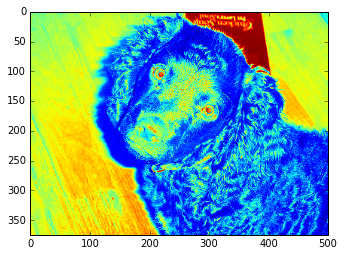

This human looks like
English_springer_spaniel


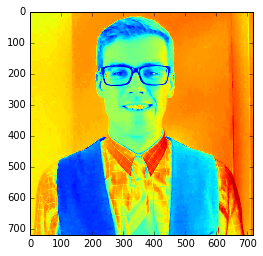

This human looks like
Dachshund


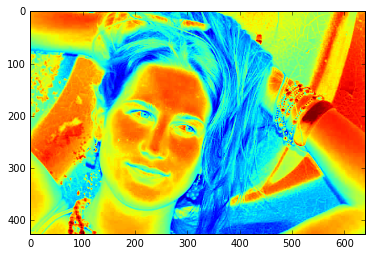

This human looks like
Silky_terrier


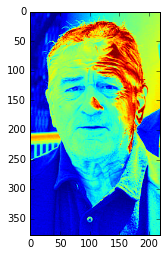

This dog seems to be a
Brittany


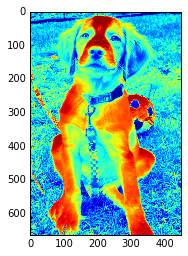

This dog seems to be a
Curly-coated_retriever


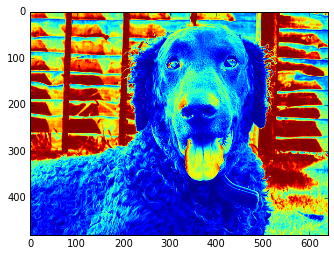

Detected human and dog. You look like a:
German_shepherd_dog


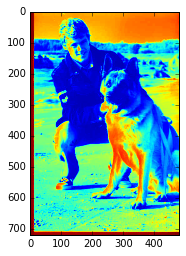

In [45]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
#List of pictures:
pictures = [
    "images/American_water_spaniel_00648.jpg",
    "images/Martin.jpg",
    "images/Anni.jpg",
    "images/DeNiro.jpg",
    "images/Brittany_02625.jpg",
    "images/Curly-coated_retriever_03896.jpg",
    "images/Figo.jpg"
]



for p in pictures:
    whichDogBreed(p)